In [3]:
import os
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import time
from zero_point import zpt
from astropy.table import Table, join, vstack

import pandas as pd

# Making a functioning query for the Gaia archive based on HEALPix pixel

In [4]:


# Query Gaia DR3 for the parallax and proper motions of a given healpix pixel
def query_gaia_healpix_pixel(healpix_pixel, nside=3):
    """
    Queries the Gaia EDR3 data for sources within a specified HEALPix pixel.

    Parameters:
        healpix_pixel: int
            The HEALPix pixel number to query.
        nside: int, optional
            The NSIDE parameter of the HEALPix pixel. Default is 3.
    Returns:
        astropy.table.Table
            The table of Gaia EDR3 sources within the specified HEALPix pixel.
    """

    norder = int(np.log2(nside))

    # Define the query
    query = f"""
    SELECT source_id, ra, dec, parallax, parallax_error, parallax_over_error,
           pm, pmra, pmra_error, pmdec, pmdec_error, ruwe, phot_g_mean_mag,
           phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, l, b, GAIA_HEALPIX_INDEX()
    FROM gaiadr3.gaia_source AS gaia
    WHERE GAIA_HEALPIX_INDEX({norder}, gaia.source_id) = {healpix_pixel}
    """

    # Run the query asynchronously
    job = Gaia.launch_job_async(query)
    result = job.get_results()
    return result

In [5]:
def plot_healpix_with_marked_pixels(pixels, nside=4):
    """
    Plot a HEALPix graticule with specific pixels marked.
    
    Parameters:
    - pixels: A list or array of HEALPix pixel indices to be marked.
    - nside: The resolution of the HEALPix grid (default is 4, corresponding to 192 pixels).
    """
    # Create a blank map with zeros
    npix = hp.nside2npix(nside)
    healpix_map = np.full(npix, hp.UNSEEN)  # Fill with UNSEEN values

    # Mark the specified pixels with a value (e.g., 1)
    healpix_map[pixels] = 1

    # Plot the map using mollweide projection and show the graticule
    hp.mollview(healpix_map, title="HEALPix Graticule with Marked Pixels", cmap='coolwarm', badcolor='white',
                norm=None, cbar=False)

    # Add a graticule for reference
    hp.graticule()

    # Display the plot
    plt.show()

In [6]:
# Sills implementation used nside=3 but wtf how can it be 3?? It needs to be a power of 2
NSIDE = 4
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    ))

Approximate resolution at NSIDE 4 is 1.5e+01 deg


In [7]:
# Number of pixels
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

192


In [30]:
hp.pixelfunc.ring2nest(NSIDE, 0)

np.int64(15)

In [31]:
hp.pixelfunc.nside2order(2)

1

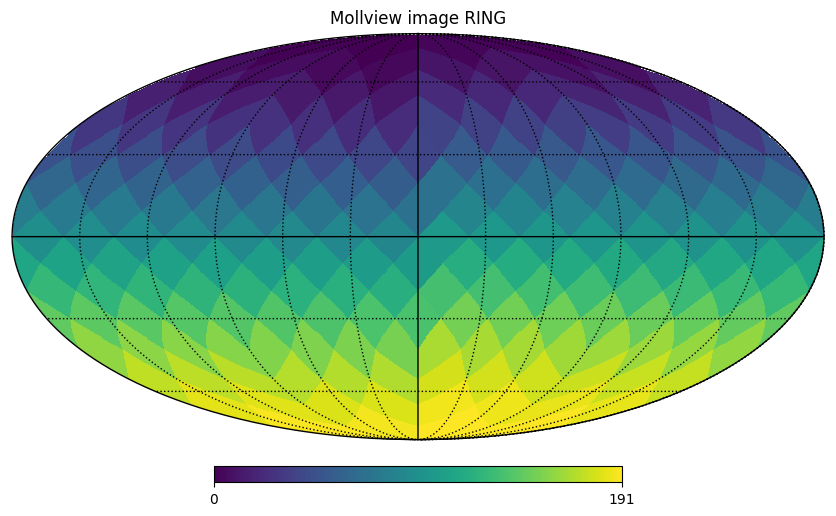

In [32]:
m = np.arange(NPIX)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

In [52]:
# Expand the specified pixel ranges into a list
pixels = np.concatenate([
    np.arange(0, 20),          # 0–19
    np.arange(22, 32),         # 22–31
    np.arange(35, 43),         # 35–42
    np.arange(46, 56),         # 46–55
    np.arange(58, 63),         # 58–62
    [65, 66],
    np.arange(69, 74),         # 69–73
    [78],
    np.arange(82, 86),         # 82–85
    np.arange(93, 97),         # 93–96
    [101, 102, 103],
    [107]
])

In [53]:
len(pixels)

73

In [50]:
# load stars that failed the tests

failed_stars_hp = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/not_in_pixels.fits')

In [57]:
passed_stars = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/sill_candidates_through_myselection.fits')

In [105]:
len(healpix_map)

108

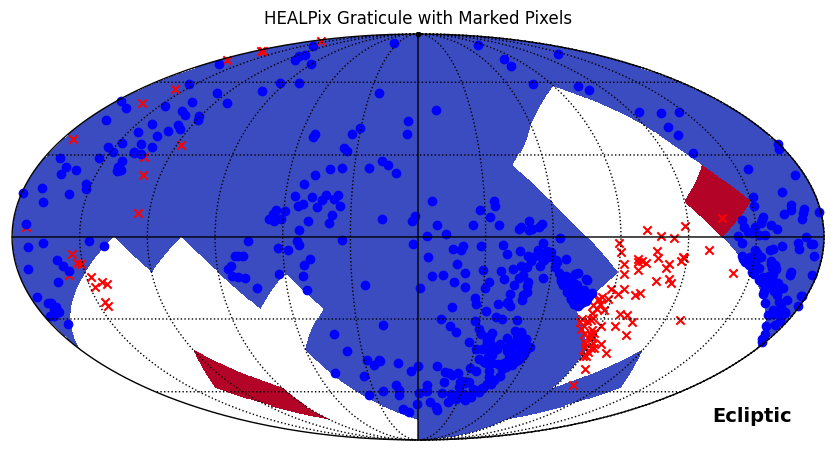

In [79]:
# Call the function to plot
#plot_healpix_with_marked_pixels(pixels, nside=3)
# also plot failed stars
# Create a blank map with zeros
nside = 3
npix = hp.nside2npix(nside)
healpix_map = np.full(npix, hp.UNSEEN)  # Fill with UNSEEN values

# Mark the specified pixels with a value (e.g., 1)
healpix_map[pixels] = 1

healpix_map[[43, 98]] = 3

# Plot the map using mollweide projection and show the graticule
hp.mollview(healpix_map, title="HEALPix Graticule with Marked Pixels", cmap='coolwarm', badcolor='white',
            norm=None, cbar=False, coord='E', nest = False)

# Add a graticule for reference
hp.graticule()
theta = np.radians(90 - failed_stars_hp['dec'])  # Colatitude in radians
phi = np.radians(failed_stars_hp['ra'])  
# Plot the stars on the map
#hp.projscatter(failed_stars_hp['l'], failed_stars_hp['b'], marker='x', color='red', lonlat = True)
hp.projscatter(phi, theta, marker='x', color='red', lonlat = False)

hp.projscatter(0, 0, marker='o', color='k', lonlat = False, s = 10)

theta_passed = np.radians(90 - passed_stars['dec'])  # Colatitude in radians
phi_passed = np.radians(passed_stars['ra'])  
hp.projscatter(theta_passed, phi_passed, marker='o', color='blue', lonlat = False)
# Display the plot
plt.show()



In [102]:

def aitoff_plot(tables, ra_col='ra', dec_col='dec', labels=None, colors=None, title="Aitoff Projection", xlim_deg=None, ylim_deg=None, **kwargs):
    """
    Creates an Aitoff projection plot with multiple datasets.

    Args:
        tables: List of Astropy Tables to plot.
        ra_col: The column name for RA (Right Ascension) in each table.
        dec_col: The column name for Dec (Declination) in each table.
        labels: List of labels for the legend (optional, same length as `tables`).
        colors: List of colors for each table plot (optional, same length as `tables`).
        title: Title for the plot.
        xlim_deg: Tuple for the X-axis limits in degrees (optional, will be converted to radians).
        ylim_deg: Tuple for the Y-axis limits in degrees (optional, will be converted to radians).
        **kwargs: Additional keyword arguments to pass to matplotlib (e.g., xlim, ylim).
    """
    # Create the Aitoff projection plot
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111, projection='aitoff')

    # Loop over each table and plot the data
    for i, table in enumerate(tables):
        # Convert RA and Dec to radians
        ra = np.deg2rad(table[ra_col])
        dec = np.deg2rad( table[dec_col])

        # Wrap RA around to [-π, π] (like you do for Mollweide or Aitoff)
        ra = np.remainder(ra + 2 * np.pi, 2 * np.pi)
        ra = ra - np.pi

        # Invert RA by multiplying by -1
        ra = -ra

        # Determine color and label for each dataset
        color = colors[i] if colors is not None else f'C{i}'  # Use given color or default to C0, C1, etc.
        label = labels[i] if labels is not None else f"Dataset {i+1}"  # Use given label or default to "Dataset 1", etc.

        # Plot the data
        ax.scatter(ra, dec, s=5, color=color, label=label, alpha=0.7)

    # Add legend
    plt.legend(loc='upper right')

    # Set the grid and labels
    ax.grid(True)
    ax.set_xlabel('RA', fontsize=12)
    ax.set_ylabel('Dec ', fontsize=12)

        ax.set_ylim(kwargs['ylim'])
    
    # Set the title
    plt.title(title)

    # Show the plot
    #plt.show()

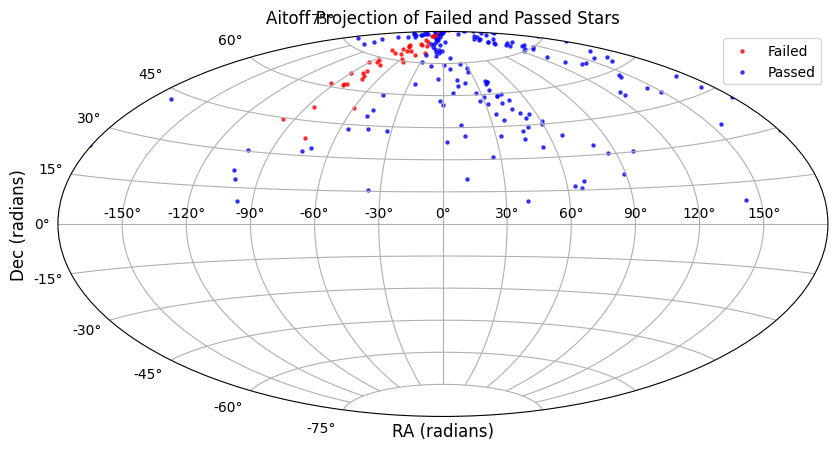

In [103]:
aitoff_plot(ra_col='ra', dec_col='dec', tables=[failed_stars_hp, passed_stars], labels=['Failed', 'Passed'], colors=['red', 'blue'], title="Aitoff Projection of Failed and Passed Stars")

In [68]:
pixels_failed_hp3 = hp.ang2pix(nside, np.radians(90 - failed_stars_hp['dec']), np.radians(failed_stars_hp['ra']), nest=False)

In [71]:
print(pixels)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  22  23  24  25  26  27  28  29  30  31  35  36  37  38  39  40
  41  42  46  47  48  49  50  51  52  53  54  55  58  59  60  61  62  65
  66  69  70  71  72  73  78  82  83  84  85  93  94  95  96 101 102 103
 107]


In [70]:
for hpp3 in pixels_failed_hp3:
    print(np.isin(hpp3, pixels))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [14]:
# read credentials from file
with open("/Users/mncavieres/Documents/2024-2/HVS/gaia_credentials.txt", "r") as f:
    username = f.readline().strip()
    password = f.readline().strip()

In [41]:
def query(HEALPix_pixel, nside = 3): #target_name must be the source id of the star to study
                        #returns a panda DataFrame with the required data to study cluster membership
                        #if the data is not present in the folder a gaia query is performed

        print('--- File not found ---')
        print('Starting Query')


        start_time = time.time()

        source_id_range = {}

        for neighbour in [HEALPix_pixel] :
            source_id_range[neighbour] = neighbour*(2**35)*(4**(12- nside)), (neighbour+1)*(2**35)*(4**(12- nside))

        from astroquery.gaia import Gaia
        ########## ADD YOUR PASSWORD AND USER ###################
        Gaia.login(user=username, password=password) 
        #check if there are too many jobs and delete the extra to allow more
    
        jobs = [job for job in Gaia.list_async_jobs()]
        # To remove all the jobs at once:
        job_ids = [job.jobid for job in jobs]
        if len(job_ids)> 5:
            Gaia.remove_jobs(job_ids)
            print(f'Deleting {len(job_ids)} jobs')

        #change mirror for speed
        #Gaia = GaiaClass(gaia_tap_server='http://gaia.ari.uni-heidelberg.de/tap') #does not work now
        #query for gaia edr3 data
        job = Gaia.launch_job_async("SELECT source_id, l, b, ra, ra_error, dec, dec_error, parallax, parallax_error,"
            " pmra, pmra_error, pmdec, pmdec_error,"
            " astrometric_params_solved, astrometric_excess_noise, astrometric_excess_noise_sig,"
            " ruwe, pseudocolour, nu_eff_used_in_astrometry, pseudocolour, ecl_lat,"
            #-- Gaia photometry
            "phot_g_mean_mag, phot_g_mean_flux,"
            "phot_bp_mean_mag, phot_bp_mean_flux,"
            "phot_rp_mean_mag, phot_rp_mean_flux,"
            "phot_bp_rp_excess_factor"
            #-- From Gaia EDR3
            " FROM gaiadr3.gaia_source"
            #-- Select only valid points
            ' WHERE ((source_id >= ' + str(source_id_range[HEALPix_pixel][0]) + ' AND source_id < ' +  str(source_id_range[HEALPix_pixel][1]) + '))'
            ' AND ra IS NOT NULL '
            ' AND dec IS NOT NULL '
            ' AND parallax IS NOT NULL '
            ' AND ruwe < 1.4 ')
        r = job.get_results()
        r['source_id'] = r['SOURCE_ID']


        #Correct parallax zero point bias

        zpt.load_tables()
        valid = r['astrometric_params_solved']>3
        zpvals = zpt.get_zpt(r['phot_g_mean_mag'][valid], r['nu_eff_used_in_astrometry'][valid], r['pseudocolour'][valid], r['ecl_lat'][valid], r['astrometric_params_solved'][valid])
        r['zpvals'] = np.nan
        r['zpvals'][valid] = zpvals
        r['parallax_corrected'] = r['parallax']-r['zpvals']

        #external query for geometrical distances
        job2 = Gaia.launch_job_async("SELECT source_id, r_med_geo, r_lo_geo, r_hi_geo"
        #    #-- From Gaia EDR3
            " FROM external.gaiaedr3_distance"
        #    #-- Select only valid points
            ' WHERE ((source_id >= ' + str(source_id_range[HEALPix_pixel][0]) + ' AND source_id < ' +  str(source_id_range[HEALPix_pixel][1]) + '))')
        r_geo =  job2.get_results()

        print(f'Query done in {time.time() - start_time}')

        # merge tables by source_id given by the left astropy table
        merged = join(r, r_geo, keys='source_id', join_type='left')

        return merged



In [49]:
hp.ang2pix(3, 0, 0, lonlat=True)

np.int64(48)

In [43]:
results_query = query(0, nside=3)

--- File not found ---
Starting Query
INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/zero_point/zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(
/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/zero_point/zpt.py:220: UserWarning: The nu_eff_used_in_astrometry of some of the 5p source(s) is outside the expected range (1.1-1.9 
                mag). Outside this range, the zero-point calculated can be seriously wrong.
  warnings.warn(
/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/zero_point/zpt.py:233: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  warnings.warn(


INFO: Query finished. [astroquery.utils.tap.core]
Query done in 29.549747943878174


In [44]:
results_query

SOURCE_ID,l,b,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_params_solved,astrometric_excess_noise,astrometric_excess_noise_sig,ruwe,pseudocolour,nu_eff_used_in_astrometry,pseudocolour_2,ecl_lat,phot_g_mean_mag,phot_g_mean_flux,phot_bp_mean_mag,phot_bp_mean_flux,phot_rp_mean_mag,phot_rp_mean_flux,phot_bp_rp_excess_factor,source_id,zpvals,parallax_corrected,r_med_geo,r_lo_geo,r_hi_geo
,deg,deg,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,mas,,,1 / um,1 / um,1 / um,deg,mag,electron / s,mag,electron / s,mag,electron / s,,,,,pc,pc,pc
int64,float64,float64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,int16,float32,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float32,float64,float32,int64,float64,float64,float32,float32,float32
4295806720,176.95107618038946,-48.901520870941965,44.99615537864534,0.10161827,0.005615226341865997,0.10133387,0.3543305595550248,0.12266381,11.93835156938502,0.13794228,-4.0806193394130865,0.13316983,31,0.3806193,2.0765078,1.1429516,--,1.5089388,--,-16.32957416215404,17.641426,1653.39471645947,18.080235,800.4295459066461,17.061232,1187.588003883822,1.2023853,4295806720,-0.028883999213576317,0.3832145587686011,2530.1523,1989.7006,3381.6545
34361129088,176.94278852482034,-48.88493355232444,45.00432028915398,0.09731972,0.021047763781174733,0.101752974,3.235017271512856,0.12045025,29.518344127131527,0.13369285,19.231654938806578,0.13392176,31,0.26741344,1.0328022,1.0578898,--,1.285487,--,-16.317212317623884,17.571619,1763.191386728999,18.86089,389.99713585371074,16.402643,2178.214858374066,1.4565701,34361129088,-0.03610200062394142,3.271119272136797,306.34778,294.81198,316.8109
38655544960,176.94476211452783,-48.88527012426483,45.004978371745516,0.017885398,0.019879675701858644,0.01877158,3.1391701154499523,0.022347411,29.686339048921702,0.023771733,19.115199913956804,0.023830384,31,0.0,0.0,1.012191,--,1.4550159,--,-16.318521975182243,14.128453,42030.60043942405,14.70305,17955.47937733753,13.410816,34263.48754002838,1.2424035,38655544960,-0.04301900044083595,3.1821891158907882,314.09866,312.24747,316.44965
309238066432,176.91426546354342,-48.87974731314605,44.99503714416301,0.32203946,0.03815169755425531,0.28350487,1.383149618921834,0.3679067,0.7103390705704198,0.42764622,-1.2901219547580884,0.36472937,95,0.0,0.0,0.98569405,1.2866279,--,1.2866279,-16.298138818420995,19.597301,272.91429606185255,20.723095,70.17439392861222,18.37631,353.6991036963679,1.5531378,309238066432,0.0013299999991431832,1.3818196189226908,745.71185,589.6301,980.24524
343597448960,176.87542435981376,-48.89837938771351,44.96389626549711,0.117176004,0.04359494367771267,0.10900387,0.196147669341387,0.13346447,6.567298538749751,0.15457995,-1.9309049068089978,0.13605057,31,0.0,0.0,0.97897136,--,1.4593558,--,-16.283806024119286,18.135033,1049.3820358447672,18.723412,442.6413531703329,17.453007,827.8577075970983,1.2107116,343597448960,-0.024879999458789825,0.22102766880017682,3076.442,2366.115,4843.747
515396233856,176.8869029734255,-48.85781465787351,44.99832707810714,0.32520288,0.0663327072023917,0.32525727,0.242393515888563,0.37432367,4.4730107982688825,0.41343114,-7.899813584834864,0.36434412,31,1.3335108,2.7009406,1.1791685,--,1.4801952,--,-16.27215908611517,19.433544,317.34312268458626,19.9288,145.8466998027093,18.911089,216.13369741198863,1.1406593,515396233856,-0.014546999707818031,0.25694051559638104,6746.08,1995.6241,10343.49
549755818112,176.95936562964246,-48.83439750417775,45.04828232129832,0.027803512,0.04825396034378256,0.026499804,1.5834770072004039,0.03442545,0.8431278207235642,0.03881713,-16.443764103221557,0.032919735,31,0.072144866,0.96563005,1.0909767,--,1.4643211,--,-16.30407740663594,14.987767,19047.581229390133,15.53609,8336.447382322891,14.2817545,15362.299344786756,1.2441866,549755818112,-0.04340599849820137,1.6268830056986052,614.9362,604.02435,626.47345
828929527040,176.91130587619824,-